In [36]:
import sys
sys.path.append('../code/functions')
sys.path.append('../../code/functions')

import numpy as np
import tiffIO as io
import neuroGraphLib as ngl
import matplotlib.pyplot as plt

from scipy import ndimage
from cluster import Cluster
from scipy.signal import convolve
from neuroGraphLib import neuroGraph
from skimage.exposure import equalize_adapthist

In [3]:
data = np.array(io.loadTiff('../data/rr46b_s1_ch1.tif'))

# Raw data

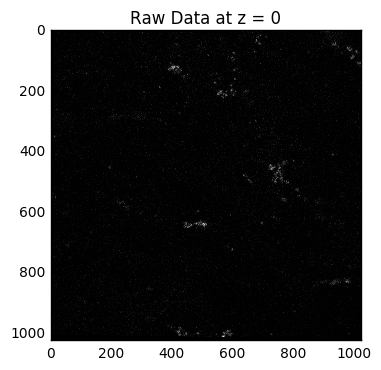

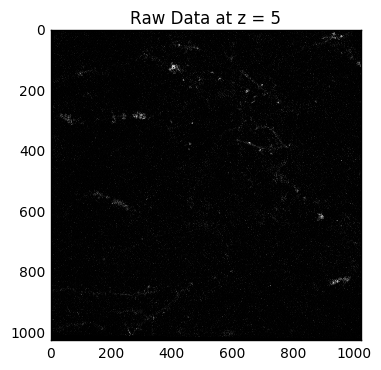

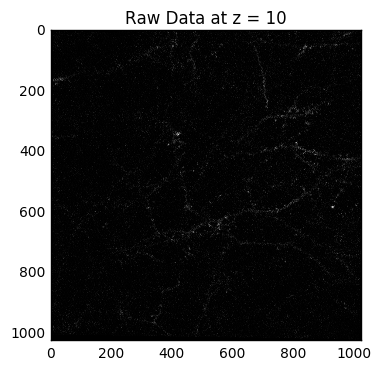

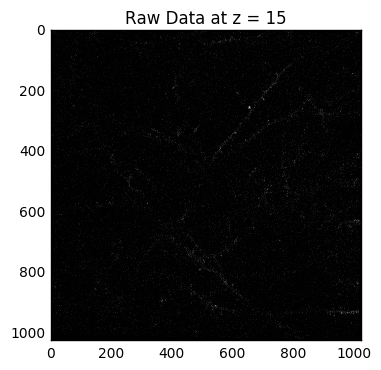

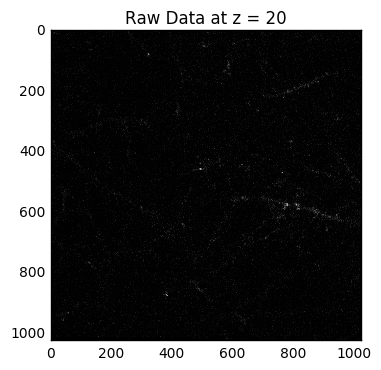

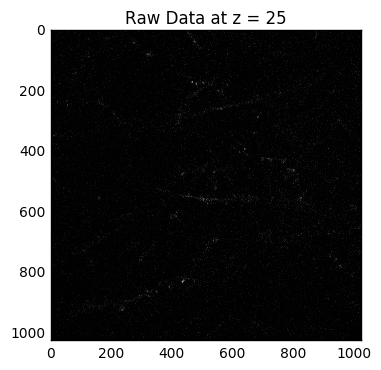

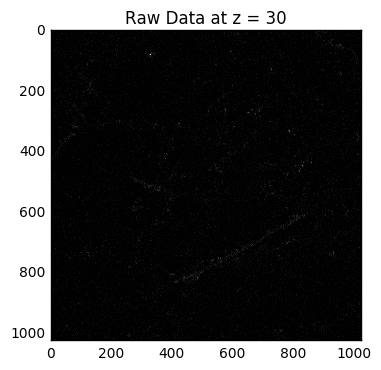

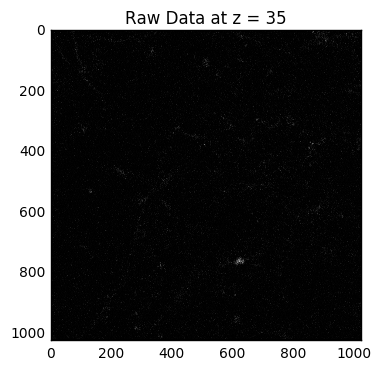

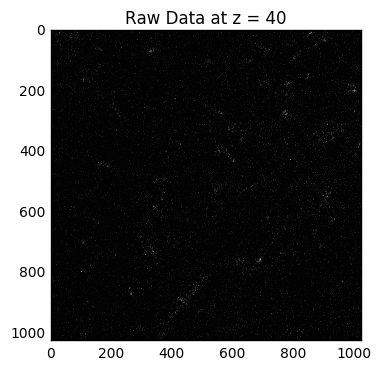

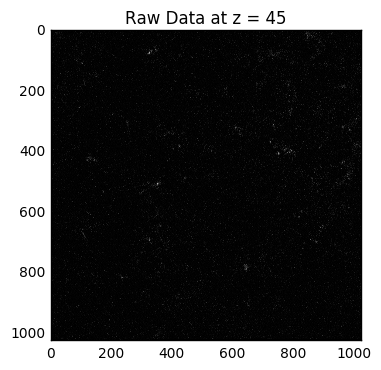

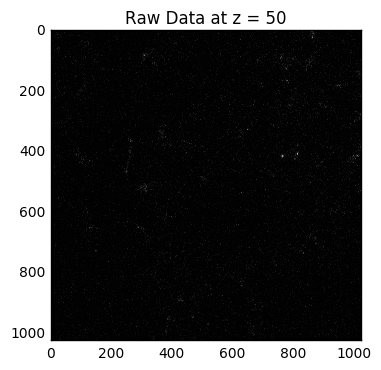

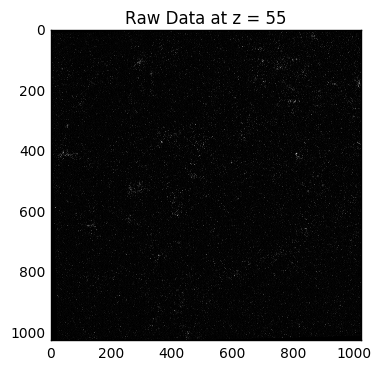

In [82]:
for i in range(0, data.shape[0], 5):
    plt.figure()
    plt.imshow(data[i], cmap='gray')
    plt.title('Raw Data at z = '+str(i))
    plt.show()

# Equalized Data

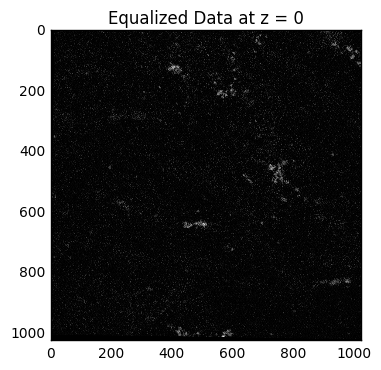

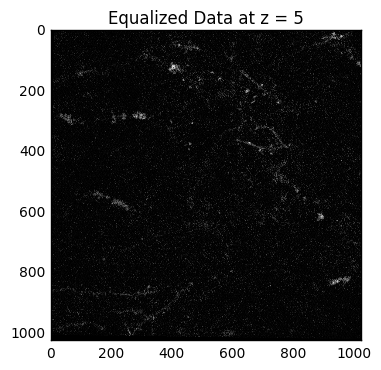

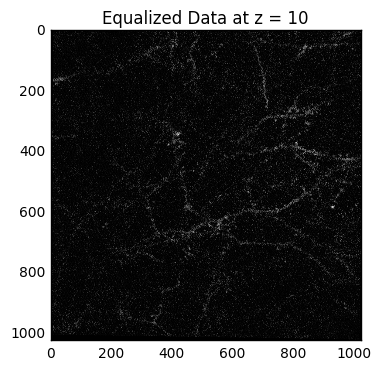

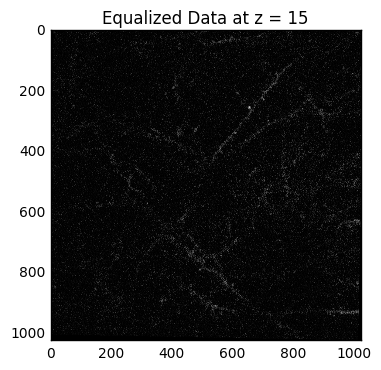

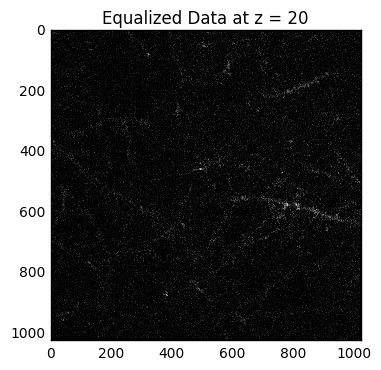

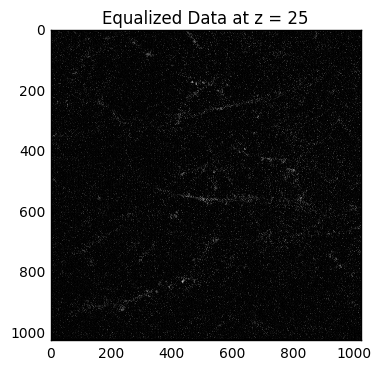

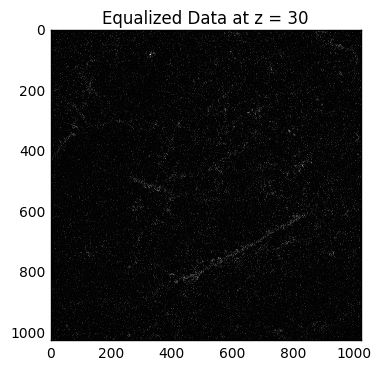

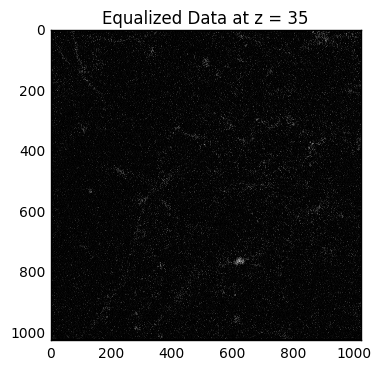

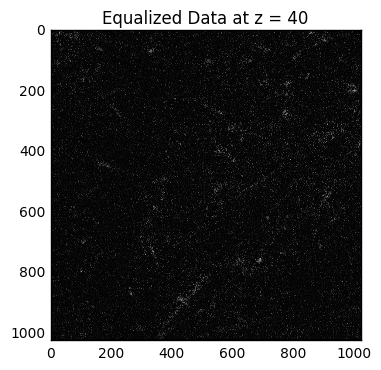

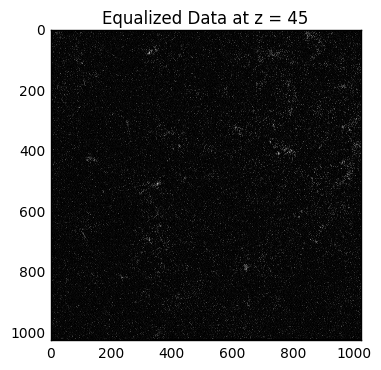

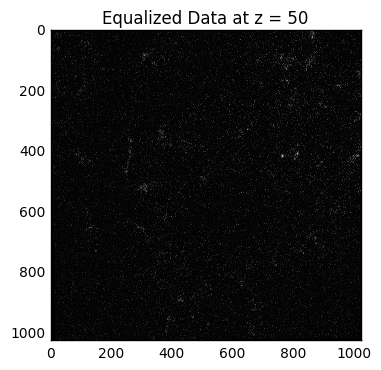

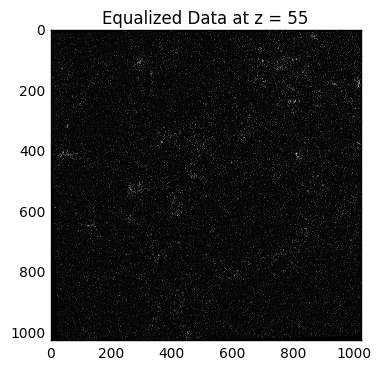

In [83]:
for i in range(0, data.shape[0], 5):
    plt.figure()
    plt.imshow(equalize_adapthist(data[i]), cmap='gray')
    plt.title('Equalized Data at z = '+str(i))
    plt.show()

# Zoom View
This is a zoomed in portion of slice 15 that we will be following throughout the notebook to give a feel for how each pipeline is performing on a local level

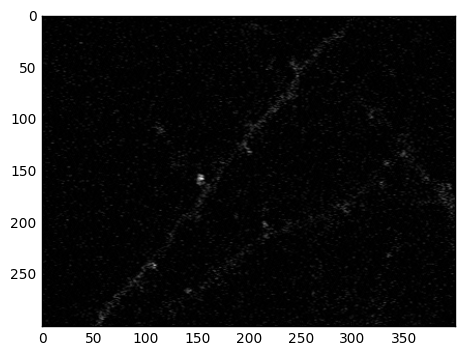

In [84]:
plt.imshow(data[15, 100:400, 500:900], cmap='gray')
plt.show()

# Pipeline v1.0

In [85]:
import connectLib as cLib

## 1. Adaptive

In [86]:
adaptiveOut = cLib.adaptiveThreshold(data, 64, 64)

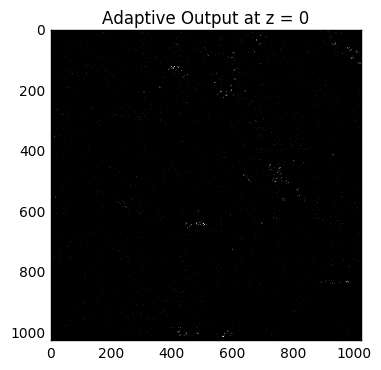

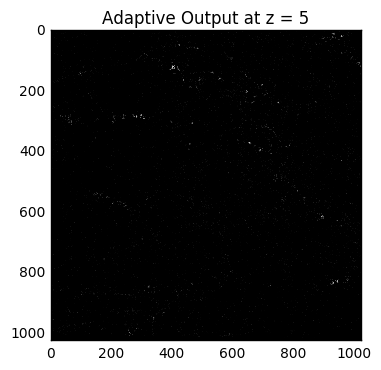

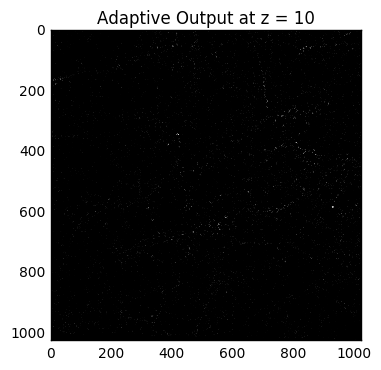

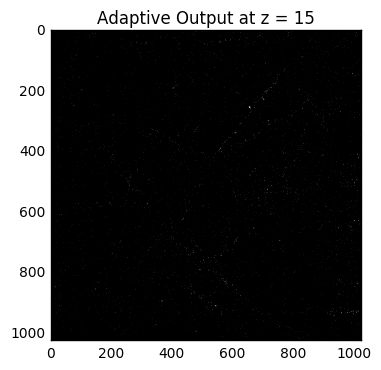

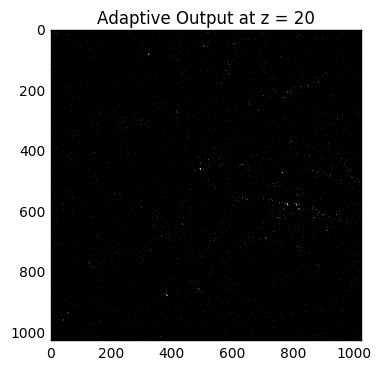

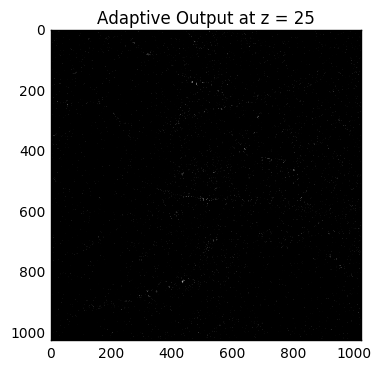

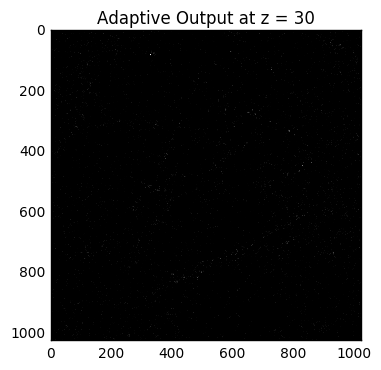

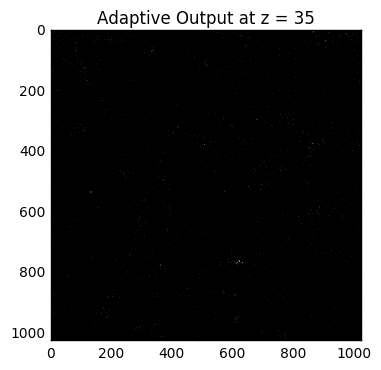

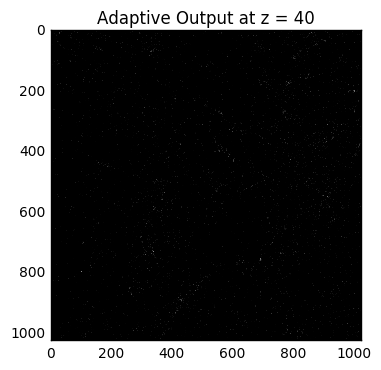

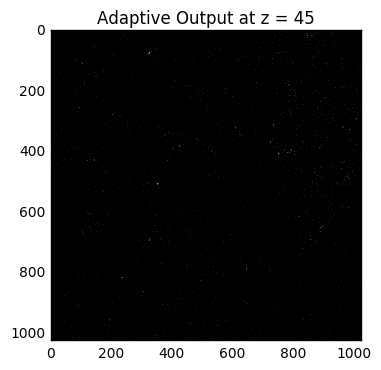

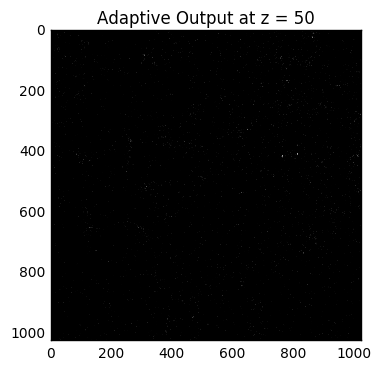

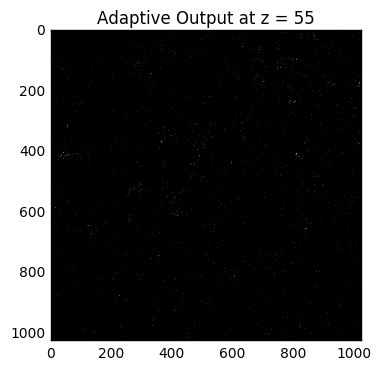

In [87]:
for i in range(0, data.shape[0], 5):
    plt.figure()
    plt.imshow(adaptiveOut[i], cmap='gray')
    plt.title('Adaptive Output at z = '+str(i))
    plt.show()

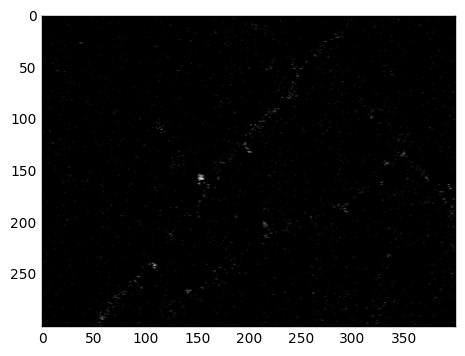

In [88]:
plt.imshow(adaptiveOut[15, 100:400, 500:900], cmap='gray')
plt.show()

## 2. Connected Component Analysis

In [89]:
knnOut = cLib.knn_filter(adaptiveOut, 2)

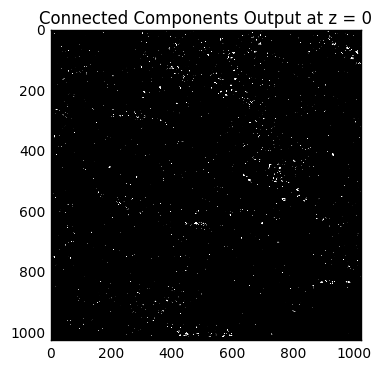

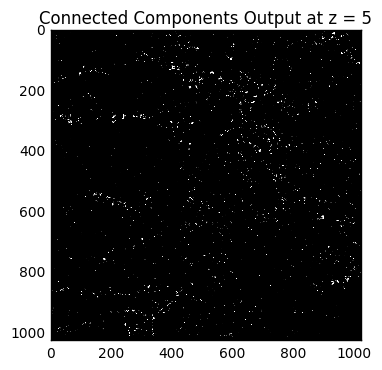

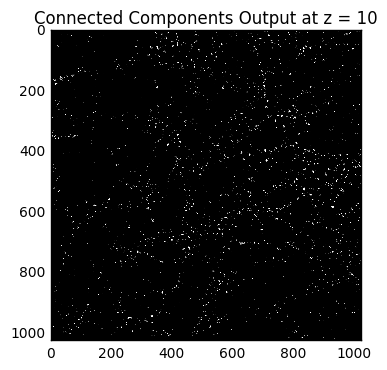

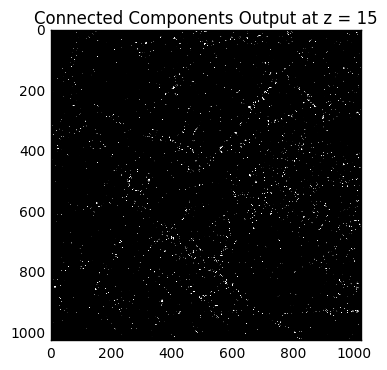

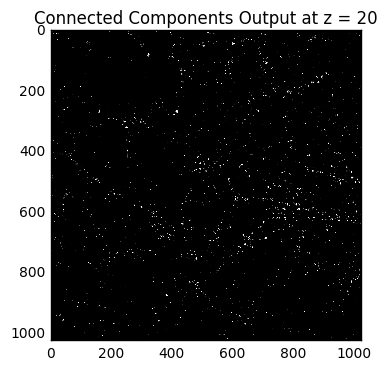

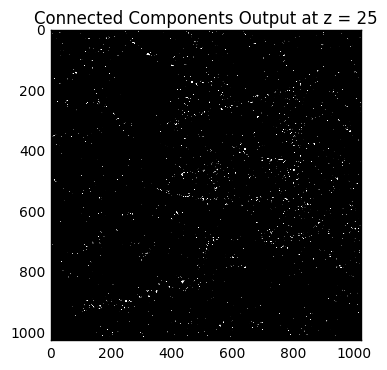

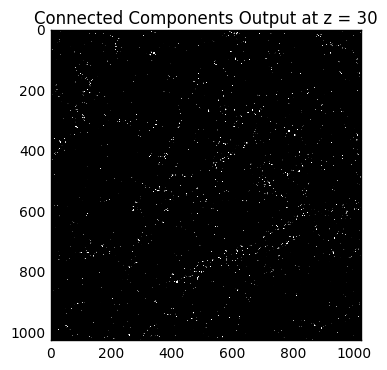

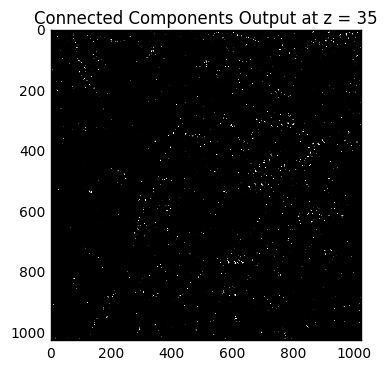

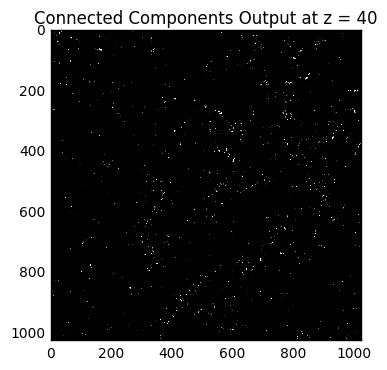

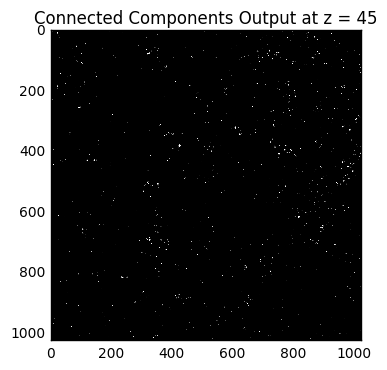

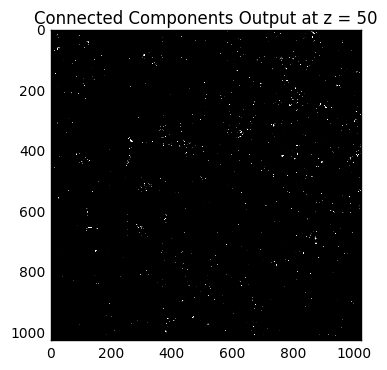

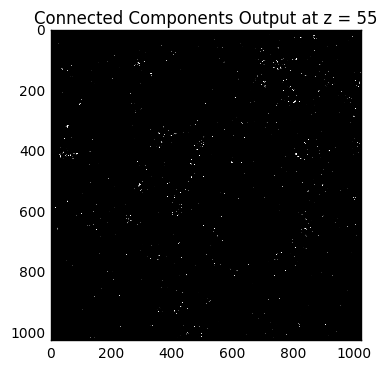

In [90]:
for i in range(0, data.shape[0], 5):
    plt.figure()
    plt.imshow(knnOut[i], cmap='gray')
    plt.title('Connected Components Output at z = '+str(i))
    plt.show()

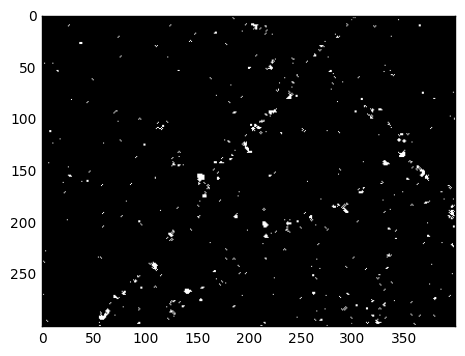

In [91]:
plt.imshow(knnOut[15, 100:400, 500:900], cmap='gray')
plt.show()

## 3 Cluster Extraction

In [92]:
s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]
connectionImg, nr_objects = ndimage.label(knnOut, s)

In [93]:
synapseLists = cLib.clusterThresh(connectionImg, 5, 100)

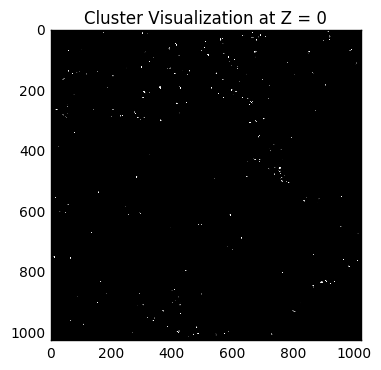

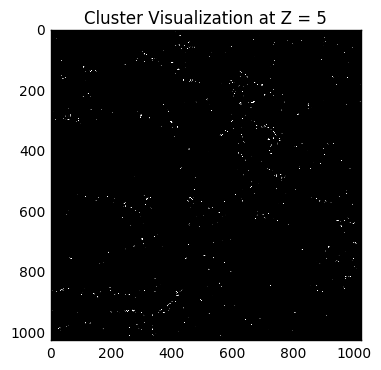

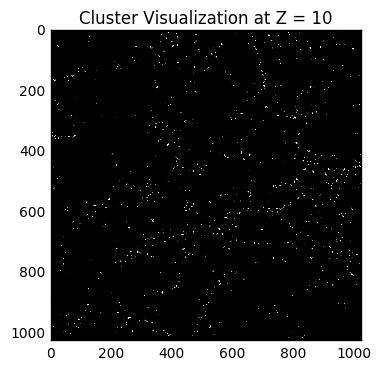

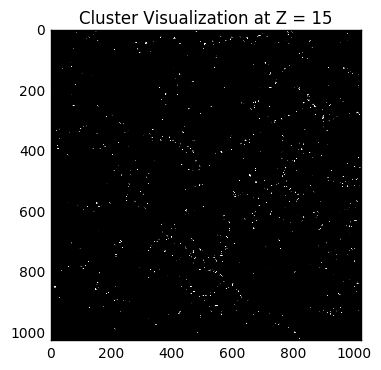

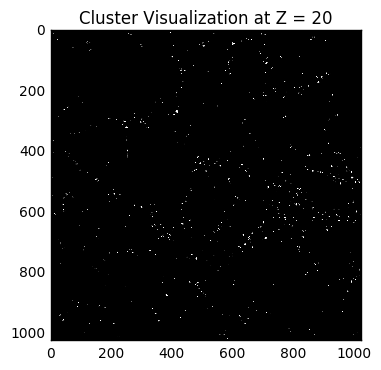

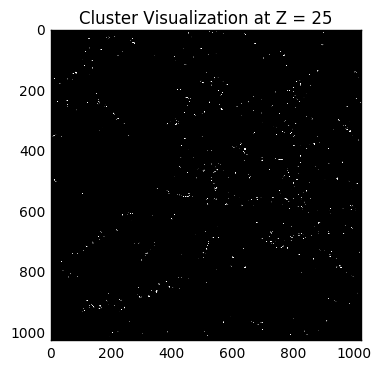

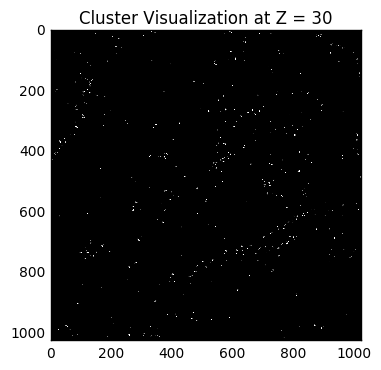

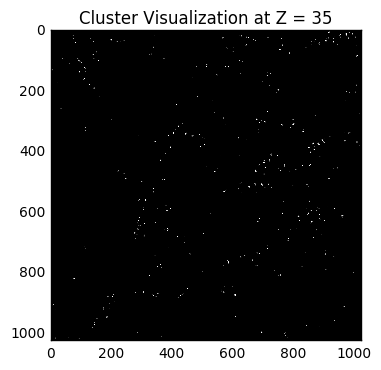

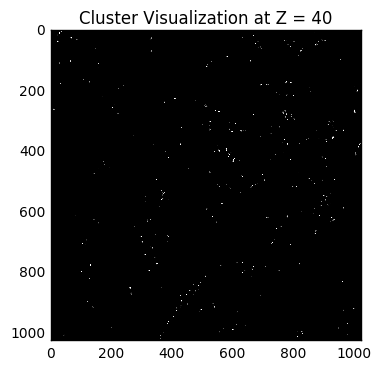

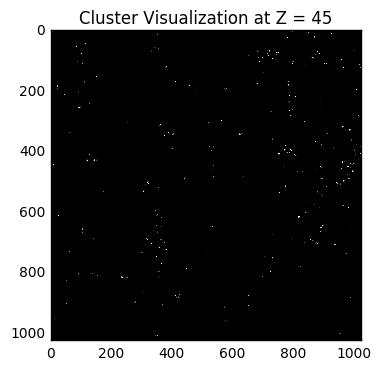

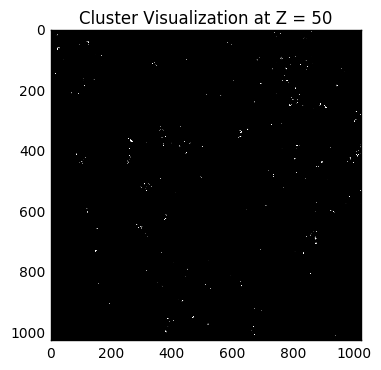

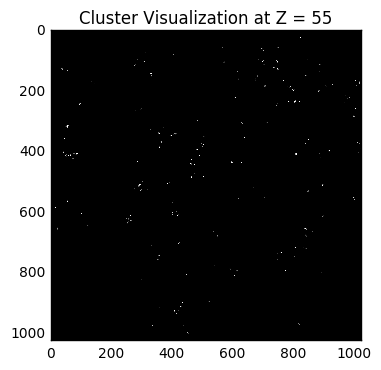

In [94]:
clusterVis = np.zeros_like(data)
for synapse in synapseLists:
    for member in synapse.members:
        clusterVis[member[0]][member[1]][member[2]] = 1

for i in range(0, clusterVis.shape[0], 5):
    plt.figure()
    plt.imshow(clusterVis[i], cmap='gray')
    plt.title('Cluster Visualization at Z = ' + str(i))
    plt.show()

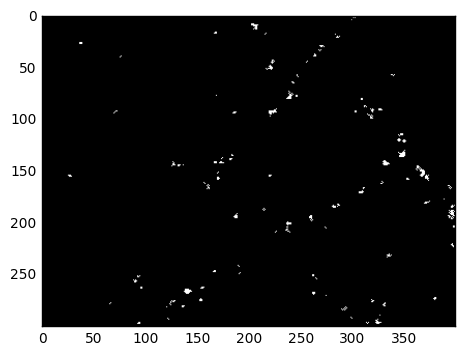

In [95]:
plt.imshow(clusterVis[15, 100:400, 500:900], cmap='gray')
plt.show()

# Pipeline v2.0
## 1. Dendrite Evolution

In [4]:
dendriteImgStack = ngl.evolveDendrites(data, epochs=10, dilations=10)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint16.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 41 fits in uint16
  warn(msg)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 46 fits in uint16
  warn(msg)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint16 without scaling because max value 49 fits in uint16
  warn(msg)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:136

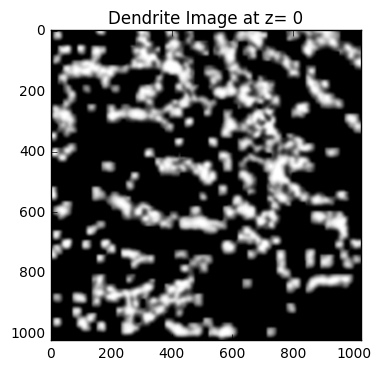

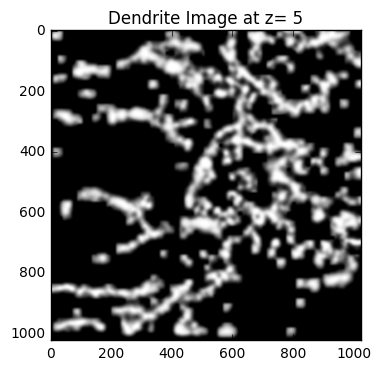

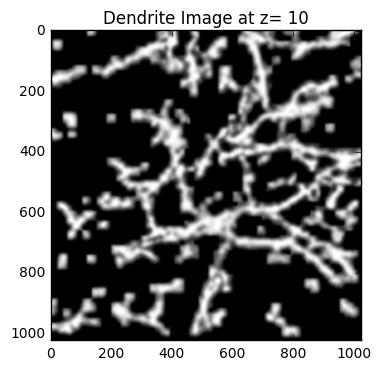

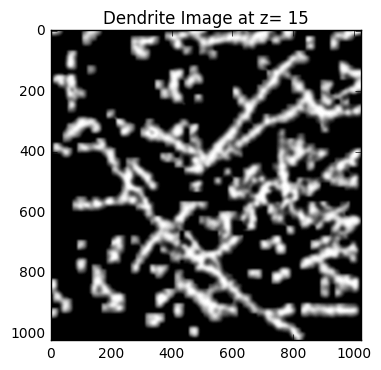

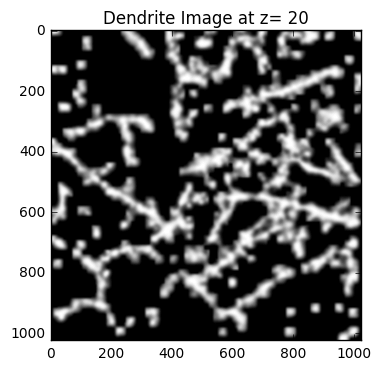

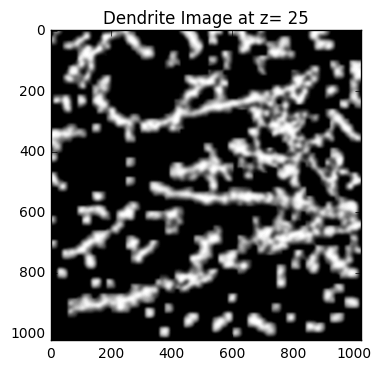

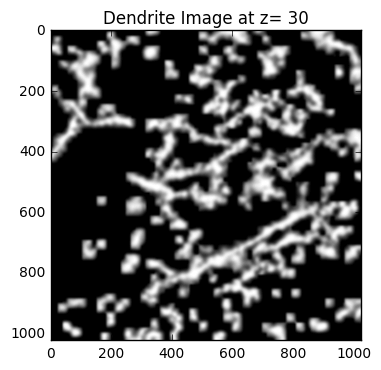

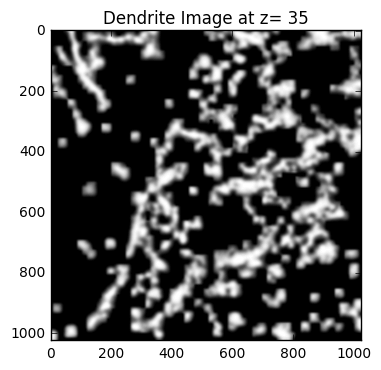

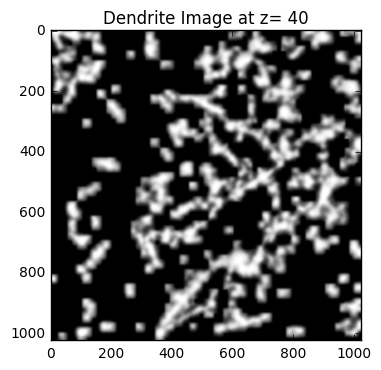

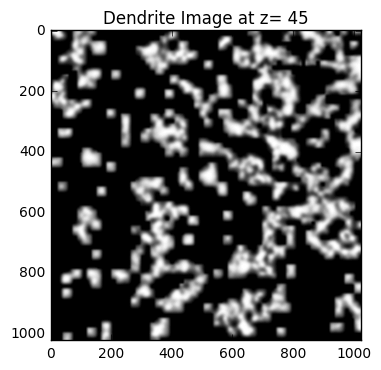

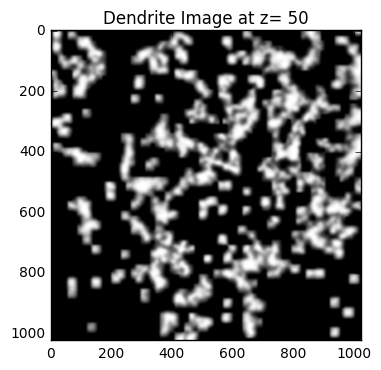

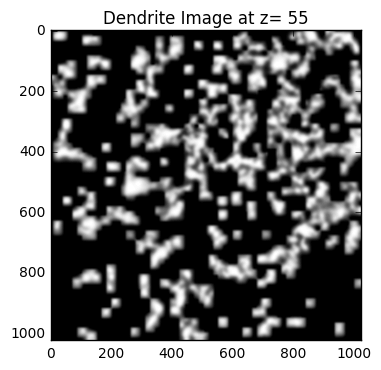

In [12]:
for i in range(0, dendriteImgStack.shape[0], 5):
    plt.figure()
    plt.imshow(dendriteImgStack[i], cmap='gray')
    plt.title('Dendrite Image at z= '+str(i))
    plt.show()

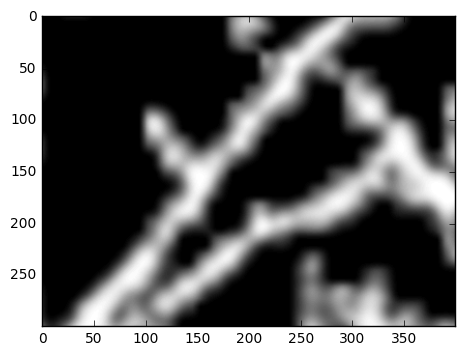

In [30]:
plt.imshow(dendriteImgStack[15, 100:400, 500:900], cmap='gray')
plt.show()

## 2. Node Estimation

In [8]:
nodeStack = np.stack([ngl.generateNodeImg(dendriteImg, 64) for dendriteImg in dendriteImgStack])

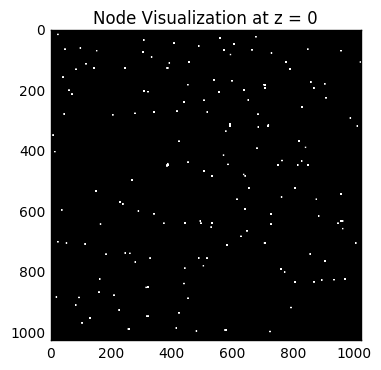

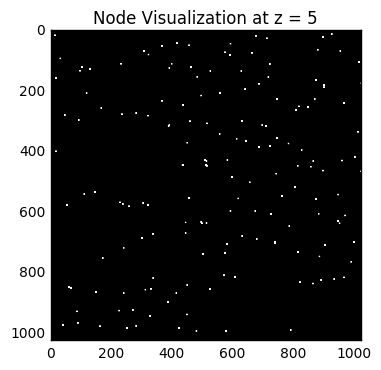

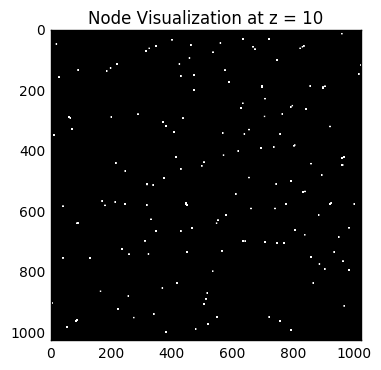

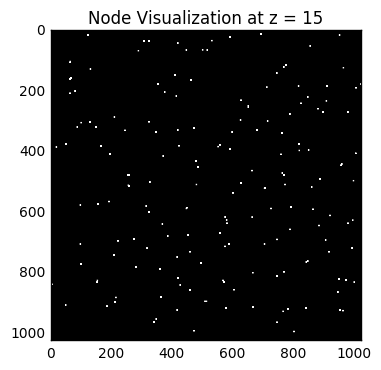

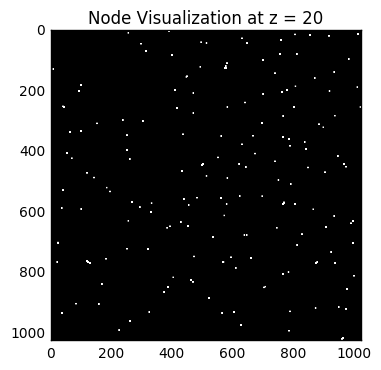

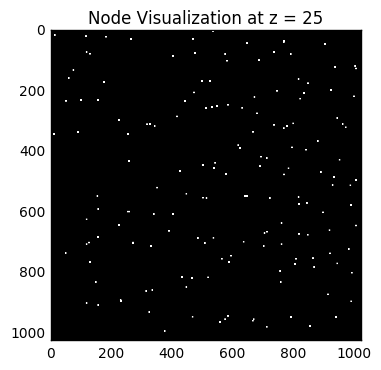

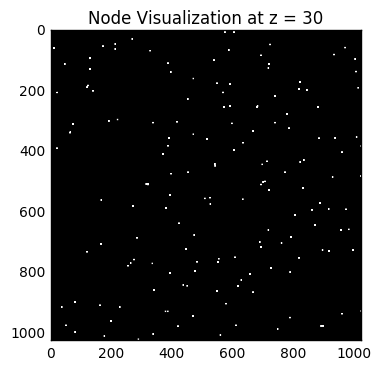

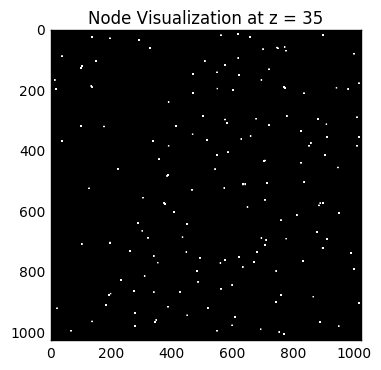

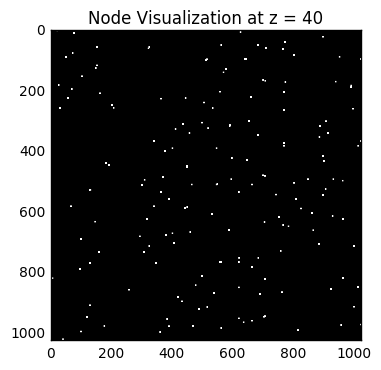

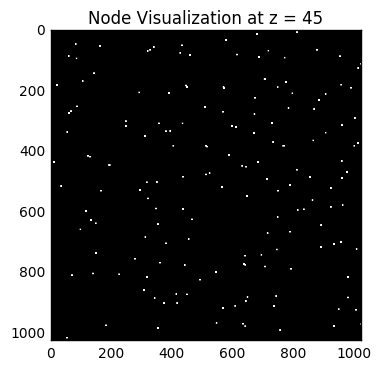

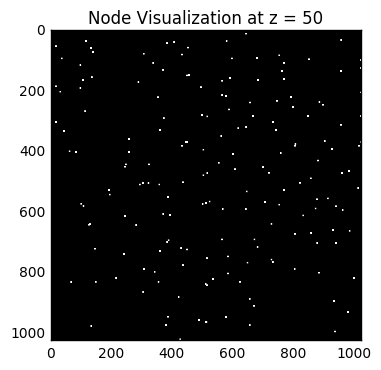

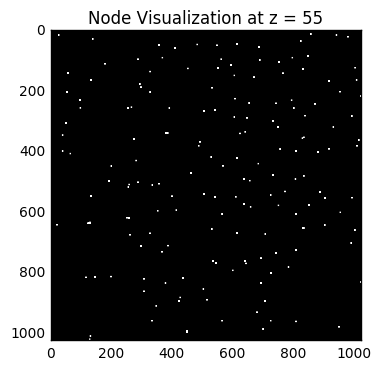

In [16]:
for i in range(0, nodeStack.shape[0], 5):
    plt.figure()
    nodeVis = np.zeros_like(nodeStack[i])
    nodes = zip(*(np.nonzero(nodeStack[i])))
    for node in nodes:
        nodeVis[max(0, node[0]-3):min(1024, node[0]+3),
                max(0, node[1]-3):min(1024, node[1]+3)] = 1
        
    plt.imshow(nodeVis, cmap='gray')
    plt.title('Node Visualization at z = '+ str(i))
    plt.show()


## 3. Edge Estimation

In [22]:
neuroGraphStack = []
for idx, nodeImg in enumerate(nodeStack):
    nodes, edges, vis = ngl.estimateGraph(nodeImg, dendriteImgStack[idx], neighbors = 10)
    neuroGraphStack.append(neuroGraph(nodes, edges, vis))

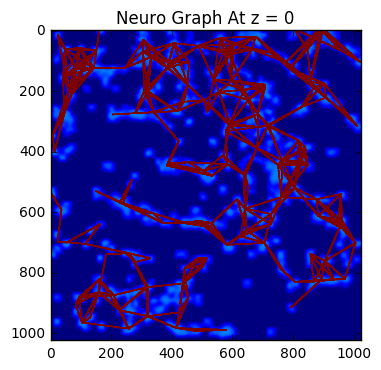

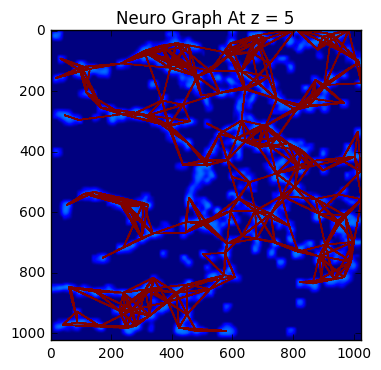

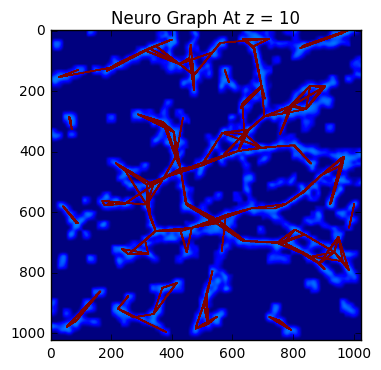

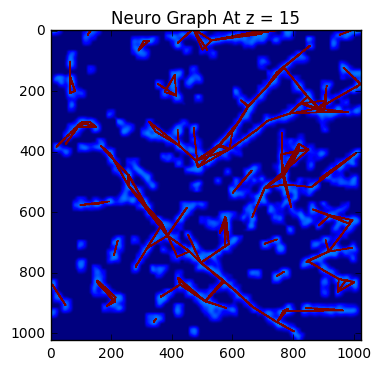

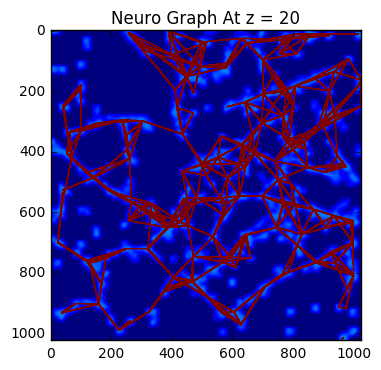

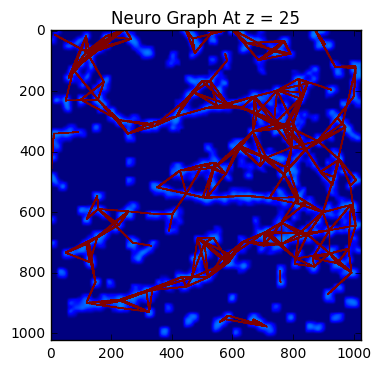

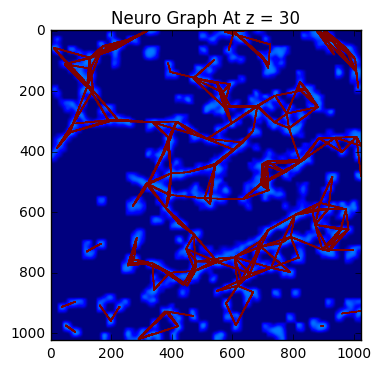

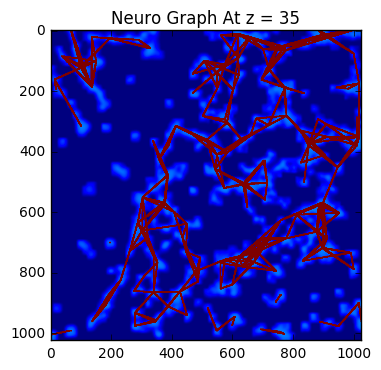

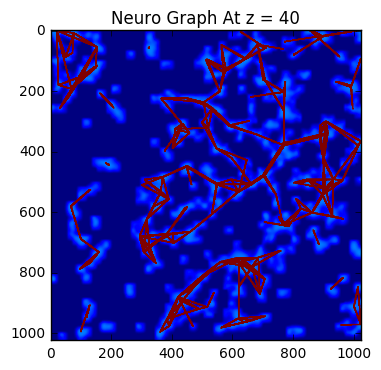

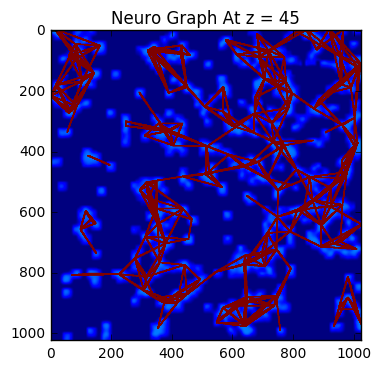

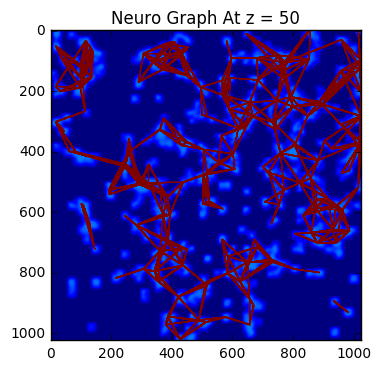

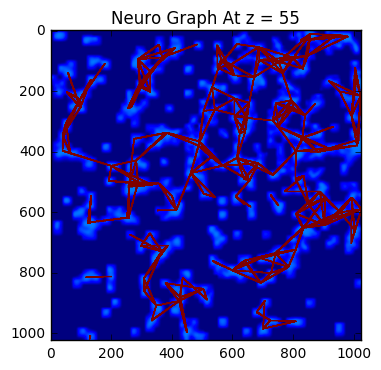

In [23]:
for i in range(0, len(neuroGraphStack), 5):
    plt.figure()
    plt.imshow(neuroGraphStack[i]._vis)
    plt.title('Neuro Graph At z = '+str(i))
    plt.show()

## 4. Synapse ROI Extraction

In [28]:
synapseROIStack = []
for i in range(len(neuroGraphStack)):
    synapseROIStack.append(ngl.getSynapseROIs(neuroGraphStack[i], data[i]))

no maxima found!


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:2239: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
../code/functions/neuroGraphLib.py:265: RuntimeWarning: invalid value encountered in greater
  valid = np.array(np.where(zscore(ROIDist) > 1.5)[0])


no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
<type 'exceptions.TypeError'>
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
no maxima found!
<type 'exceptions.TypeError'>
no maxima found!
<type 'excep

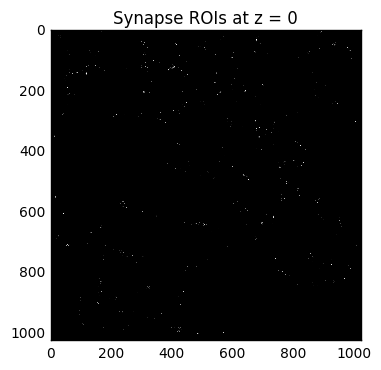

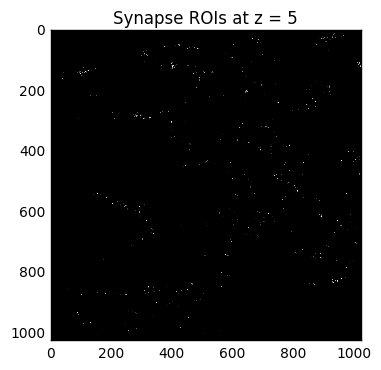

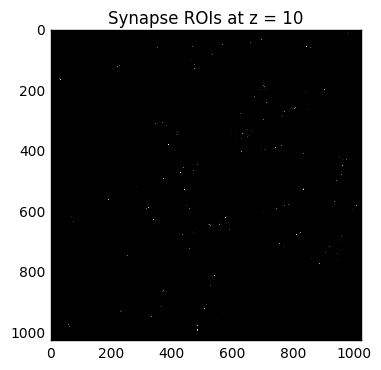

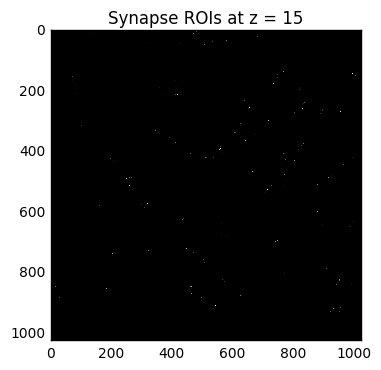

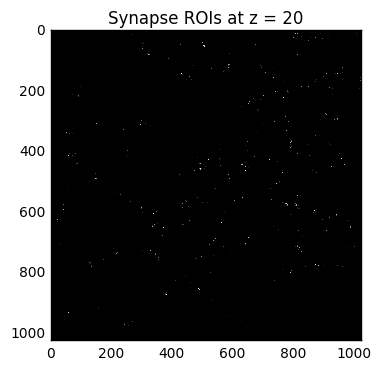

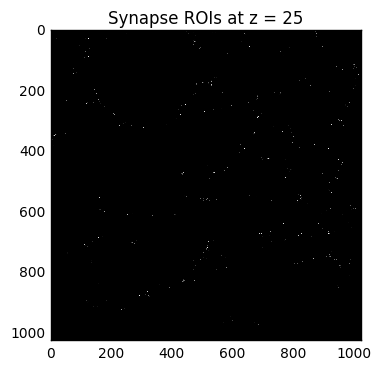

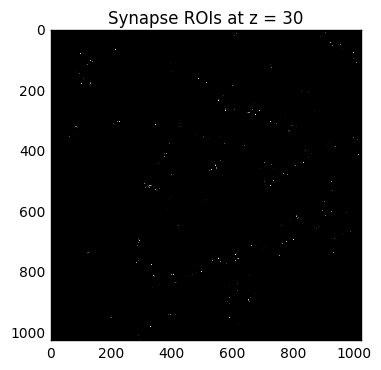

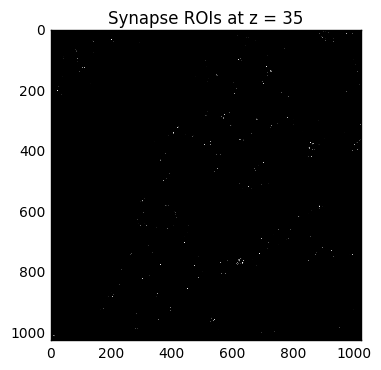

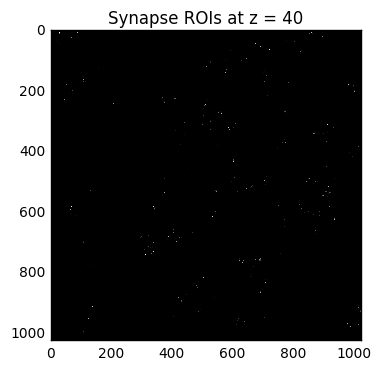

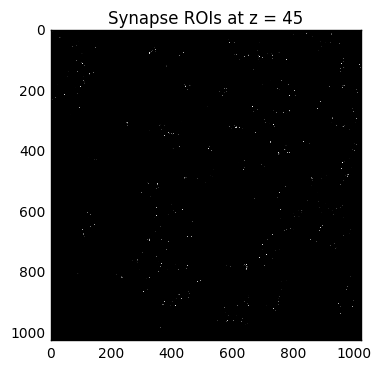

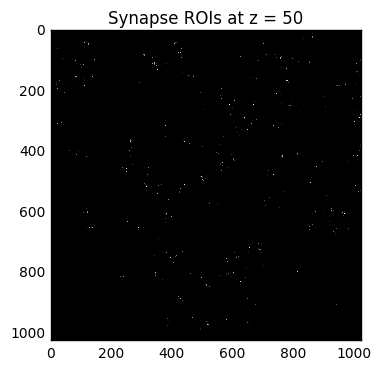

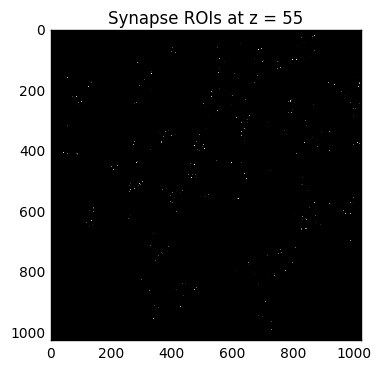

In [29]:
roiImgStack = []
for synapseROIs in synapseROIStack:
    curImg = np.zeros_like(data[0])
    for y, x in synapseROIs:
        curImg[y][x] = 1
    roiImgStack.append(curImg)
    
for i in range(0, len(roiImgStack), 5):
    plt.figure()
    plt.imshow(roiImgStack[i], cmap='gray')
    plt.title('Synapse ROIs at z = ' + str(i))
    plt.show()

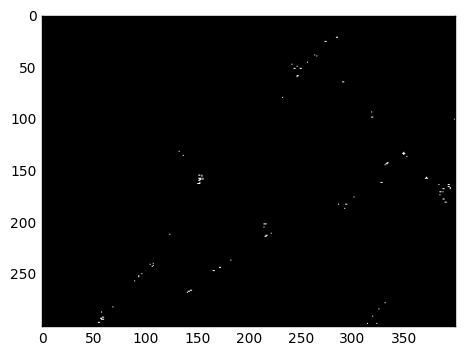

In [35]:
plt.imshow(roiImgStack[15][100:400, 500:900], cmap='gray')
plt.show()

## 5. ROI Density Smoothing

In [60]:
def smoothROI(roiImg):
    kernel_a = np.ones((8, 8))
    kernel_b = np.ones((4, 4))
    kernel_c = np.ones((2, 2))
    roiSmooth = np.add(convolve(roiImg, kernel_a)[0:1024, 0:1024],
                       np.add(convolve(roiImg, kernel_b)[0:1024 ,0:1024],
                              convolve(roiImg, kernel_c)[0:1024, 0:1024]))
    return roiSmooth

In [61]:
smoothROIStack = np.stack([smoothROI(roiImg) for roiImg in roiImgStack])

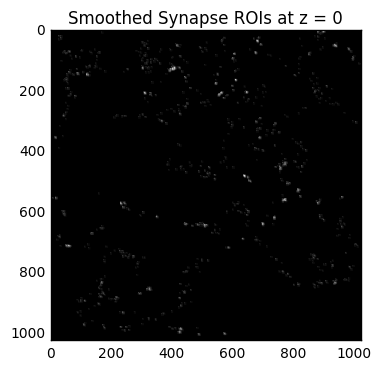

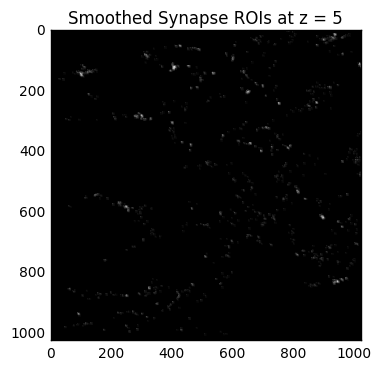

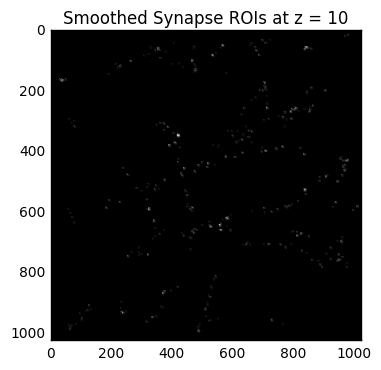

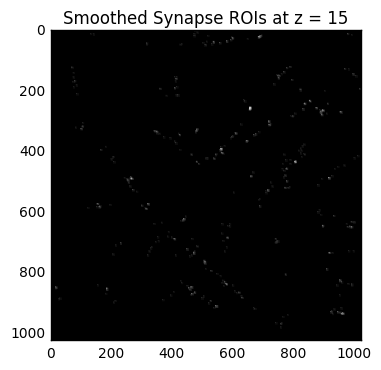

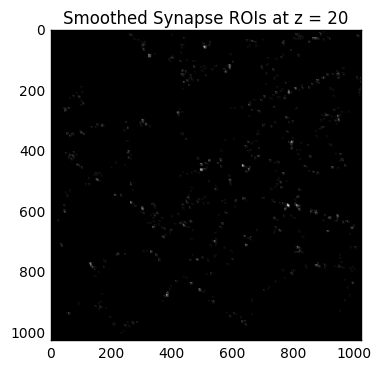

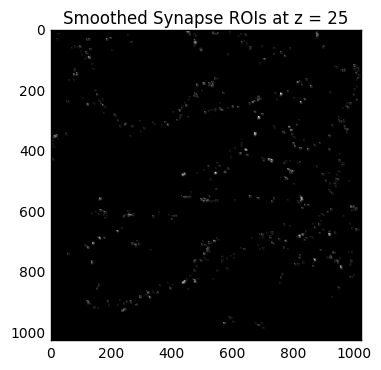

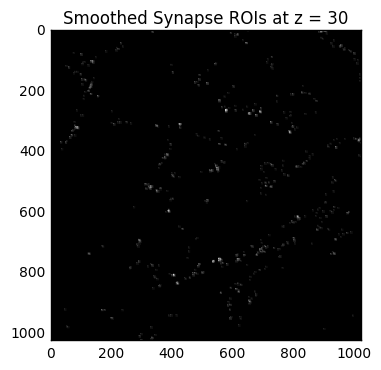

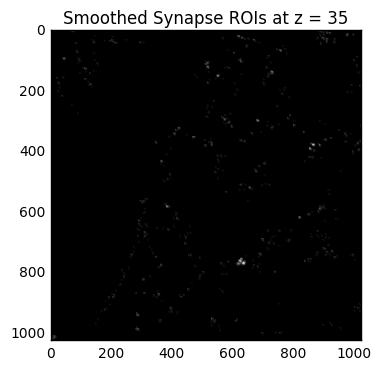

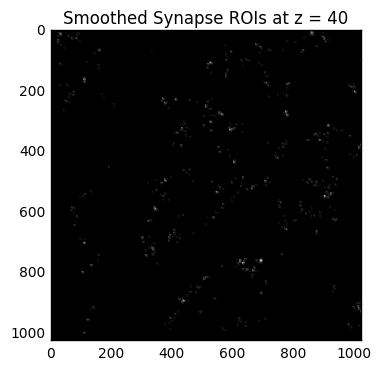

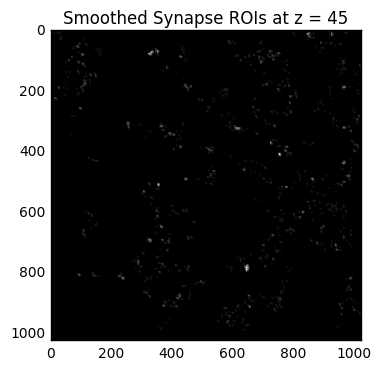

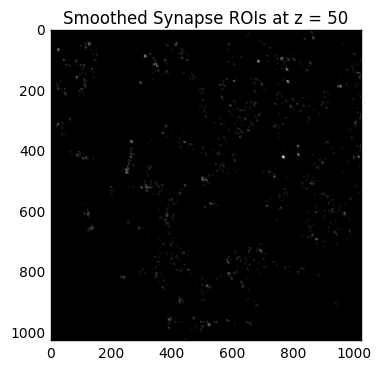

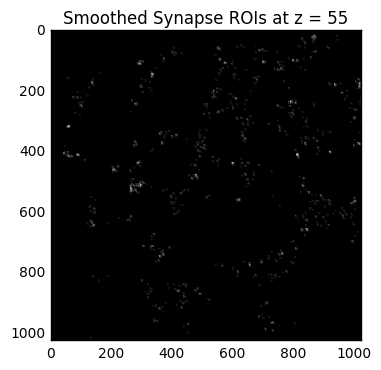

In [62]:
for i in range(0, len(smoothROIStack), 5):
    plt.figure()
    plt.imshow(smoothROIStack[i], cmap='gray')
    plt.title('Smoothed Synapse ROIs at z = ' + str(i))
    plt.show()

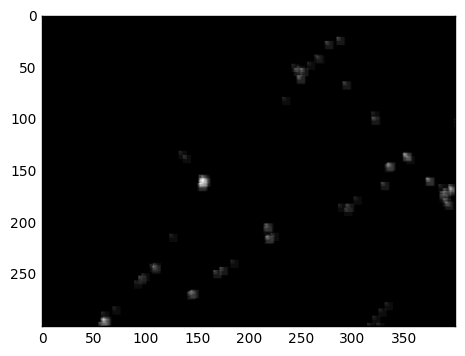

In [63]:
plt.imshow(smoothROIStack[15][100:400, 500:900], cmap='gray')
plt.show()

# Output Comparison

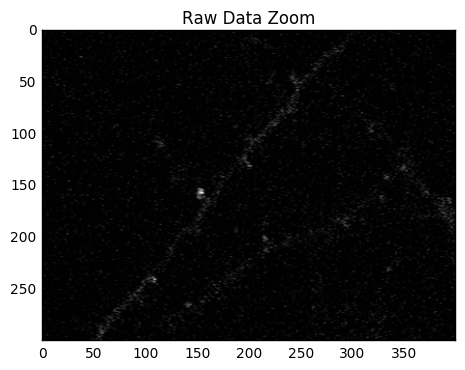

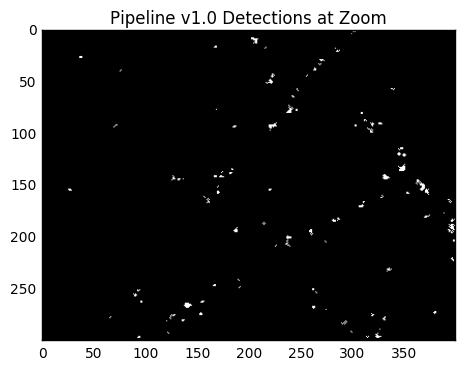

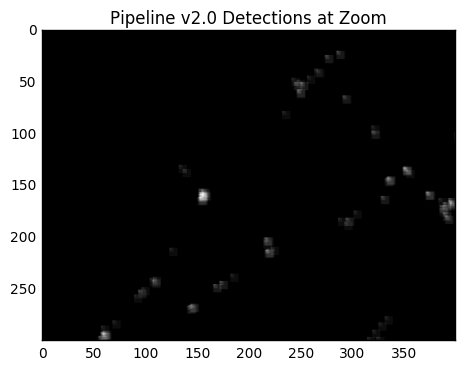

In [100]:
plt.figure()
plt.imshow(data[15, 100:400, 500:900], cmap='gray')
plt.title('Raw Data Zoom')
plt.show()

plt.figure()
plt.imshow(clusterVis[15, 100:400, 500:900], cmap='gray')
plt.title('Pipeline v1.0 Detections at Zoom')
plt.show()

plt.figure()
plt.imshow(smoothROIStack[15][100:400, 500:900], cmap='gray')
plt.title('Pipeline v2.0 Detections at Zoom')
plt.show()